c:\Users\Pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Device set to use cpu


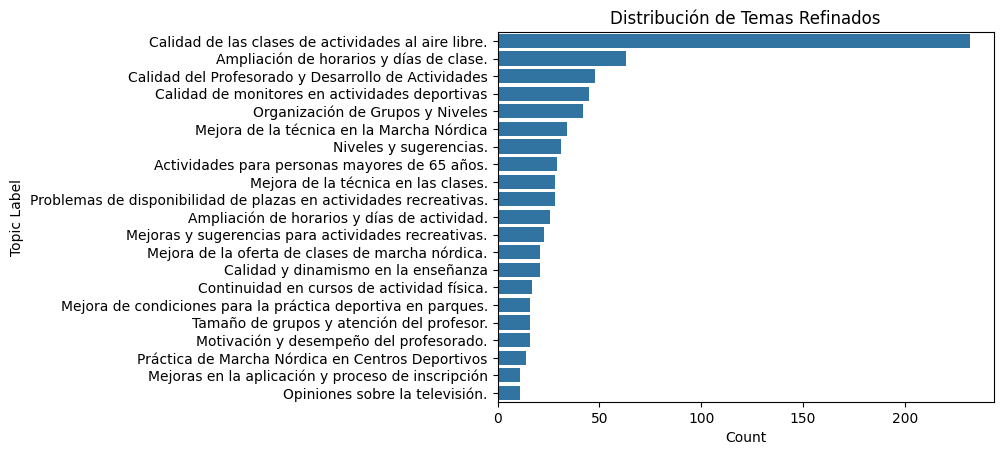

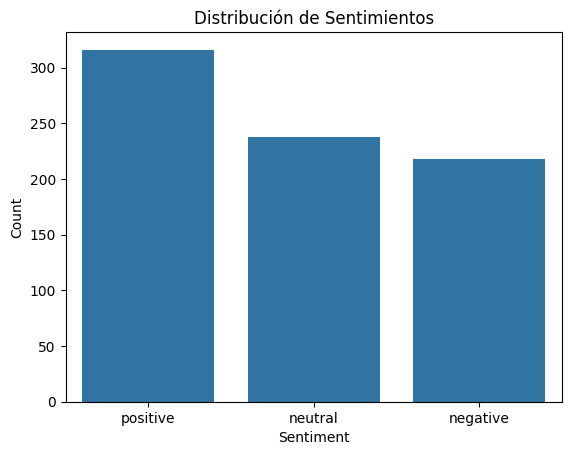


Topic Frequency Table (Refined with GPT):
                                          Topic Label  Count
0   Calidad de las clases de actividades al aire l...    232
1             Ampliación de horarios y días de clase.     63
2   Calidad del Profesorado y Desarrollo de Activi...     48
3      Calidad de monitores en actividades deportivas     45
4                    Organización de Grupos y Niveles     42
5           Mejora de la técnica en la Marcha Nórdica     34
6                              Niveles y sugerencias.     31
7       Actividades para personas mayores de 65 años.     29
8                 Mejora de la técnica en las clases.     28
9   Problemas de disponibilidad de plazas en activ...     28
10        Ampliación de horarios y días de actividad.     26
11  Mejoras y sugerencias para actividades recreat...     23
12   Mejora de la oferta de clases de marcha nórdica.     21
13                Calidad y dinamismo en la enseñanza     21
14         Continuidad en cursos de activi

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from unidecode import unidecode
from transformers import pipeline
import nltk
from collections import Counter
from bertopic import BERTopic
from openai import OpenAI

# Descargar recursos necesarios
nltk.download('punkt')
nltk.download('stopwords')

# Cargar el modelo de SpaCy para español
nlp = spacy.load("es_core_news_sm")

# Cargar el dataset
df = pd.read_excel("C:/Users/Pc/Desktop/Estudios Madrid deporte_proyecto/Marcha_Nordica/NORDICA_RESULTADOS_2023.xlsx")

# Eliminar tildes en todas las columnas de texto
df = df.applymap(lambda x: unidecode(str(x)) if isinstance(x, str) else x)

# Definir la columna de verbatims
verbatim_col = '14_Para finalizar, indique aquellas sugerencias que puedan contribuir a la mejora del programa.'

# Crear una versión limpia de la columna
df[f'{verbatim_col}_clean'] = df[verbatim_col].copy()

# Función de preprocesamiento con SpaCy
def preprocess_text(text):
    if isinstance(text, str) and text.strip():
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
        tokens = word_tokenize(text)
        
        stop_words = set(stopwords.words('spanish'))

        # Aplicar lematización con SpaCy
        doc = nlp(' '.join(tokens))
        tokens = [token.lemma_ for token in doc if token.text not in stop_words]
        
        return ' '.join(tokens)
    return None

# Aplicar preprocesamiento
df[f'{verbatim_col}_clean'] = df[f'{verbatim_col}_clean'].apply(preprocess_text)

# Filtrar filas donde el verbatim procesado no esté vacío
filtered_df = df[df[f'{verbatim_col}_clean'].notna()].copy()

# Modelo de topic modeling con BERTopic
model = BERTopic()
topics, probs = model.fit_transform(filtered_df[f'{verbatim_col}_clean'])

# Asignar los topics a cada verbatim
filtered_df['topics'] = topics

# Obtener los términos más representativos de cada tema
topic_terms = model.get_topics()

# Agrupar verbatims por topic y seleccionar hasta 20 ejemplos por topic
grouped_verbatims = filtered_df.groupby('topics')[verbatim_col].apply(lambda x: x.sample(min(len(x), 20)).tolist()).to_dict()

# Conectar con OpenAI para generar nombres de topics
client = OpenAI(api_key="")  # Asegúrate de reemplazar con tu API Key de OpenAI

def generate_topic_name(topic_id, verbatims):
    """
    Usa GPT para generar un nombre de topic basado en los verbatims del cluster y las palabras clave de BERTopic.
    """
    terms = [term for term, _ in topic_terms.get(topic_id, [])]
    prompt = f"""Estás analizando respuestas de una encuesta y dando un nombre al tema del que hablan estos verbatims.
    Aquí tienes 20 respuestas agrupadas bajo el mismo tema, junto con algunas palabras clave generadas por un modelo de topic modeling:

    - Palabras clave del modelo: {', '.join(terms[:5])}
    - Ejemplos de respuestas:
    {verbatims}

    Basándote en esto, genera un nombre breve, conciso y claro para el tema que represente bien su contenido.
    Solo responde con el nombre del tema, sin añadir nada más.
    """

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "system", "content": "Eres un asistente experto en análisis de encuestas."},
                  {"role": "user", "content": prompt}],
        max_tokens=20,
        temperature=0.5
    )

    return response.choices[0].message.content.strip()

# Generar nombres de topics con GPT
topic_names = {topic_id: generate_topic_name(topic_id, verbatims) for topic_id, verbatims in grouped_verbatims.items()}

# Asignar los nombres generados al dataset
filtered_df['topic_labels'] = filtered_df['topics'].map(topic_names)

# Fusionar los topics de vuelta en el dataframe original
df = df.merge(filtered_df[['topics', 'topic_labels']], how='left', left_index=True, right_index=True)

# Modelo de análisis de sentimiento con BERT Multilingual
sentiment_model = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment")

def analyze_sentiment(text):
    if isinstance(text, str) and text.strip():
        sentiment = sentiment_model(text[:512])[0]['label']
        return 'positive' if '5' in sentiment or '4' in sentiment else 'negative' if '1' in sentiment or '2' in sentiment else 'neutral'
    return 'neutral'

df['sentiment'] = df[verbatim_col].apply(analyze_sentiment)

# Visualizar la distribución de topics
df_filtered = df[df['topics'].notna()]
topic_counts = df_filtered['topic_labels'].value_counts().reset_index()
topic_counts.columns = ['Topic Label', 'Count']

sns.barplot(x='Count', y='Topic Label', data=topic_counts)
plt.title('Distribución de Temas Refinados')
plt.show()

# Visualizar la distribución de sentimientos
sentiment_counts = df_filtered['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']
sns.barplot(x='Sentiment', y='Count', data=sentiment_counts)
plt.title('Distribución de Sentimientos')
plt.show()

# Mostrar las tablas de topics y sentimientos
print("\nTopic Frequency Table (Refined with GPT):")
print(topic_counts)

print("\nSentiment Frequency Table:")
print(sentiment_counts)

# Guardar los datos procesados (opcional)
# df.to_csv("processed_survey_data.csv", index=False)
